In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix  
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
from sklearn.externals.six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus

import functions_used.functions_used as func

//anaconda3/envs/sklearn-env/lib/python3.7/site-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


In [4]:
file_train = "~/ds/proj3/tanzania-water-wells/data/raw/training-set-values.csv" #x_train, training set values data
file_target_train = "~/ds/proj3/tanzania-water-wells/data/raw/training-labels.csv" #y_train, training set labels
file_test = "~/ds/proj3/tanzania-water-wells/data/raw/test-set.csv" #x_test, test set data

In [82]:
features = pd.read_csv(file_train)
targets = pd.read_csv(file_target_train)
X_test = pd.read_csv(file_test)

In [93]:
targets['status_group'] = targets['status_group'].map({'non functional':'needs repair','functional needs repair':'needs repair','functional':'functional'})

## Functions 

In [80]:
def model_preprocessing(df, feature_list, ohe, train=True):
    print('Beginning numerical cleaning...')
    df = numerical_clean(df, feature_list)
    print('Completed numerical cleaning.\n')
    
    print('Removing the target from the cleaned data frame...')
    target = df['status_group']
    print("---Length of target: ", len(target))
    df = df.drop(columns='status_group', axis = 1)
    print("---Shape of dataframe: ", df.shape)
    
    print("Reading the remaining columns as independent features\n")
    obj_list = obj_lister(df)
    
    
    print('Begining "object" cleaning...')
    ohe_df = obj_preprocessing(df, obj_list, ohe, train)
    print("---Shape of ohe_df: ", ohe_df.shape)
    print('...ending "object" cleaning.')
    
    print("Joining the cleaned numerical and object dataframes together.")
    # dropping the independent features from X
    df = df.drop(obj_list, axis=1)
    # joining the OHE dataframe to X
    model_df = df.join(ohe_df)
    print('Returning the main (independent features, X) and target (y) data frames...')
    return model_df, target


def numerical_clean(df, feature_list):
    #this takes the df and the list of numerical features to clean
    df = df[feature_list]
    print("check: df shape = ", df.shape)
    print('---Dropping 0 longitudes...')
    df = drop_zero_long(df)
    print("check: df shape = ", df.shape)
    print("---Replace 0's with average constructor year...")
    df = con_year_avg(df)
    print("check: df shape = ", df.shape)
    print('...returning a cleaned dataframe of numerical values.')
    return df

def drop_zero_long(df):
    return df.drop(df[df.longitude==0].index)

def con_year_avg(df):
    con_year_nonzero = df.replace(0, np.nan)
    avg_con_years = pd.DataFrame(con_year_nonzero.groupby(['extraction_type']).mean()['construction_year'])
    df = df.join(avg_con_years, rsuffix = '_avg', on = 'extraction_type')
    df = df.reset_index()
    df = df.drop(['index'], axis = 1)
#    df['construction_year'] = df.apply(con_year, axis=1)
    df = df.drop(['construction_year_avg'], axis = 1)
    return df

def obj_lister(df):
    # returns a list of columns that contain Objects
    obj_list = []
    for col in df.select_dtypes([np.object]):
        obj_list.append(col)
    return obj_list

def obj_preprocessing(df, obj_list, ohe, train = True):
    '''
    
    '''
    df_current = df[obj_list]
    # Clean the df if there are NaNs
    df = NaN_cleaning(df_current)
    #OHE data
    array_current = ohe_data(df, ohe, train)
    #return a dataframe of the OHE data
    return pd.DataFrame(array_current)


def NaN_cleaning(df):
    # Replace NaN with "unknown" bin
    print('---Replacing NaN with "unknown" bin...')
    df = df.replace(np.nan, 'unknown')
    print(f'---Check: Number of rows with nulls: {len(df[df.isna().any(axis=1)])}...\n')
    return df.reset_index(drop=True)

def ohe_data(df, ohe, train):
    #OHE the data
    print('Begin one hot encoding data...')
    if train:
        array_current = ohe.fit_transform(df).toarray()
    else:
        array_current = ohe.transform(df).toarray()
    print('Finish one hot encoding data...\n')
    return array_current


# Function to calculate accuracy 
# from: https://www.geeksforgeeks.org/decision-tree-implementation-python/
def calc_accuracy(y_test, y_pred): 
      
    print("Confusion Matrix: ", 
    confusion_matrix(y_test, y_pred)) 
      
    print ("Accuracy : ", 
    accuracy_score(y_test,y_pred)*100) 
      
    print("Report : ", 
    classification_report(y_test, y_pred)) 
  


## Model 1: Decision Tree; Gini criterion

In [162]:
#note the target is listed in here

features_list = ['basin', 'region', 'scheme_management', 'scheme_name',
       'extraction_type', 'management', 'payment', 'water_quality', 'quantity',
       'source', 'waterpoint_type','gps_height', 'longitude', 'latitude', 
       'region_code', 'district_code', 'population', 'construction_year', 'status_group']   


In [163]:
ohe = OneHotEncoder(handle_unknown = 'ignore')

- Perform a train test split of the "training data" given in the problem. 
- Join the training data (X and y) together.


In [164]:
X_train, X_test, y_train, y_test = train_test_split(features, targets, random_state=42)

In [165]:
joined_train = X_train.join(y_train, lsuffix='_l', rsuffix='_r')

- Perform the pre-processing. Clean the numerical data. Perform One Hot Encoding.

In [166]:
joined_train_processed, y_train = func.model_preprocessing(joined_train, features_list, ohe, train = True)

Beginning numerical cleaning...
check: df shape =  (44550, 19)
---Dropping 0 longitudes...
check: df shape =  (43211, 19)
---Replace 0's with average constructor year...
check: df shape =  (43211, 19)
...returning a cleaned dataframe of numerical values.
Completed numerical cleaning.

Removing the target from the cleaned data frame...
---Length of target:  43211
---Shape of dataframe:  (43211, 18)
Reading the remaining columns as independent features

Begining "object" cleaning...
---Replacing NaN with "unknown" bin...
---Check: Number of rows with nulls: 0...

Begin one hot encoding data...
Finish one hot encoding data...

---Shape of ohe_df:  (43211, 2572)
...ending "object" cleaning.
Joining the cleaned numerical and object dataframes together.
Returning the main (independent features, X) and target (y) data frames...


- Train the decision tree with training data.

In [167]:
dtc = DecisionTreeClassifier(random_state=42, max_depth=5) 
dtc.fit(joined_train_processed, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

- Repeat the pre-processing on the test data.
- Join the testing data (X and y) together.

In [168]:
joined_test = X_test.join(y_test, lsuffix='_l', rsuffix='_r')

- Preprocess the testing data.

In [169]:
joined_test_processed, y_test = func.model_preprocessing(joined_test, features_list, ohe, train=False)

Beginning numerical cleaning...
check: df shape =  (14850, 19)
---Dropping 0 longitudes...
check: df shape =  (14377, 19)
---Replace 0's with average constructor year...
check: df shape =  (14377, 19)
...returning a cleaned dataframe of numerical values.
Completed numerical cleaning.

Removing the target from the cleaned data frame...
---Length of target:  14377
---Shape of dataframe:  (14377, 18)
Reading the remaining columns as independent features

Begining "object" cleaning...
---Replacing NaN with "unknown" bin...
---Check: Number of rows with nulls: 0...

Begin one hot encoding data...
Finish one hot encoding data...

---Shape of ohe_df:  (14377, 2572)
...ending "object" cleaning.
Joining the cleaned numerical and object dataframes together.
Returning the main (independent features, X) and target (y) data frames...


- Make predictions with the test data.

In [170]:
predicts = dtc.predict(joined_test_processed)

- Check the score of the model.

In [171]:
dtc.score(joined_test_processed, y_test) #x_test, y_test from split

0.7203171732628504

In [172]:
func.calc_accuracy(y_test, predicts)

Confusion Matrix:  [[7529  333]
 [3688 2827]]
Accuracy :  72.03171732628503
Report :                precision    recall  f1-score   support

  functional       0.67      0.96      0.79      7862
needs repair       0.89      0.43      0.58      6515

    accuracy                           0.72     14377
   macro avg       0.78      0.70      0.69     14377
weighted avg       0.77      0.72      0.70     14377



## Model #2

In [179]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier


param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [10, 25, 50]
}
gs = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5)

In [174]:
gs.fit(joined_train_processed, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=50, n_jobs=None,
                                              oob_score=False, random_state=1,
                                    

In [175]:
gs.best_params_

{'criterion': 'gini', 'max_depth': 50}

In [176]:
gs.best_score_

0.8163661223277648

In [177]:
gs.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=50, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [194]:
rfc = RandomForestClassifier(n_estimators=50, random_state=42, bootstrap=True, max_depth = 50)

In [195]:
rfc.fit(joined_train_processed,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=50, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [196]:
rfc_predicts = rfc.predict(joined_test_processed)

In [197]:
rfc.score(joined_test_processed, y_test)

0.8200598177644849

In [198]:
confusion_matrix(y_test, rfc_predicts)

array([[6780, 1082],
       [1505, 5010]])

In [207]:
func.calc_accuracy(y_test, rfc_predicts)

Confusion Matrix:  [[6780 1082]
 [1505 5010]]
Accuracy :  82.0059817764485
Report :                precision    recall  f1-score   support

  functional       0.82      0.86      0.84      7862
needs repair       0.82      0.77      0.79      6515

    accuracy                           0.82     14377
   macro avg       0.82      0.82      0.82     14377
weighted avg       0.82      0.82      0.82     14377



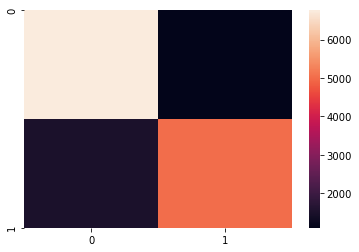

In [188]:
sns.heatmap(confusion_matrix(y_test, rfc_predicts))

In [199]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import euclidean as euc
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
# from visualize import generate_moons_df, preprocess, plot_boundaries

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
np.random.seed(0)

In [200]:
features_list = ['basin', 'region', 'scheme_management', 'scheme_name',
       'extraction_type', 'management', 'payment', 'water_quality', 'quantity',
       'source', 'waterpoint_type','gps_height', 'longitude', 'latitude', 
       'region_code', 'district_code', 'population', 'construction_year', 'status_group']   

scaler = StandardScaler()
scaler.fit(joined_train_processed)
X_train_scaled = scaler.transform(joined_train_processed)
X_test_scaled = scaler.transform(joined_test_processed)

In [201]:
knn = KNeighborsClassifier(n_neighbors=3)
# knn.fit(joined_train_processed, y_train)

knn.fit(X_train_scaled,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [202]:
sk_preds = knn.predict(X_test_scaled)

In [ ]:
knn.score(X_test_scaled,y_test)

In [204]:
func.calc_accuracy(y_test,sk_preds)

Confusion Matrix:  [[6456 1406]
 [1664 4851]]
Accuracy :  78.64644918967795
Report :                precision    recall  f1-score   support

  functional       0.80      0.82      0.81      7862
needs repair       0.78      0.74      0.76      6515

    accuracy                           0.79     14377
   macro avg       0.79      0.78      0.78     14377
weighted avg       0.79      0.79      0.79     14377



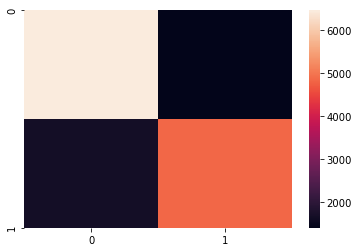

In [217]:
sns.heatmap(confusion_matrix(y_test, sk_preds))

# Model 4

In [110]:
logreg = LogisticRegression(solver='newton-cg', max_iter=20, random_state=42, multi_class = 'multinomial')

logreg.fit(joined_train_processed, y_train)

confusion_matrix(y_test, logreg.predict(joined_test_processed))

//anaconda3/envs/sklearn-env/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


array([[6827, 1035],
       [2591, 3924]])